# RNN Model for Text Classification - Layer Count Experiment

This notebook experiments with different numbers of RNN layers to analyze their impact on model performance for sentiment analysis using the NusaX-Sentiment dataset.

In [ ]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report

sys.path.append('../../../')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-05-30 07:48:58.494937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748566138.514515    6942 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748566138.520154    6942 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748566138.537171    6942 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748566138.537205    6942 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748566138.537207    6942 computation_placer.cc:177] computation placer alr

## Data Loading and Preprocessing

We'll use the NusaXLoader to handle tokenization and embedding.

In [8]:
from src.models.src.models.base_model.utils.nusax_loader import NusaXLoader

# Initialize data loader
data_loader = NusaXLoader(
    batch_size=32,
    max_sequence_length=100,
    vocab_size=10000,
    add = True
)

# Load datasets and initialize vocabulary 
train_dataset = data_loader.get_dataset("train")  # This initializes the vocabulary
val_dataset = data_loader.get_dataset("valid")
test_dataset = data_loader.get_dataset("test")

# Get raw test data for evaluation
x_test, y_test = data_loader.get_vectorized_data("test")

# Now we can get the dataset characteristics
vocab_size = len(data_loader.get_vocabulary())
num_classes = data_loader.num_classes
max_sequence_length = data_loader.max_sequence_length

print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")
print(f"Maximum sequence length: {max_sequence_length}")

Vocabulary size: 2836
Number of classes: 3
Maximum sequence length: 100


## Model Building Function

We'll create a function to build RNN models with different numbers of layers.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def build_rnn_model(num_layers, units_per_layer, embedding_dim=100):
    """Build an RNN model with the specified number of layers"""
    model = Sequential()
    
    # Add embedding layer with explicit input shape
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_sequence_length,
            mask_zero=True  # This helps with variable length sequences
        )
    )
    
    # Add RNN layers
    for i in range(num_layers):
        # If it's the last RNN layer, don't return sequences
        return_sequences = i < num_layers - 1
        model.add(SimpleRNN(units_per_layer[i], return_sequences=return_sequences))
        model.add(Dropout(0.2))  # Add dropout after each RNN layer
    
    # Add final dense layer
    model.add(Dense(num_classes, activation="softmax"))
    
    # Compile the model
    model.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    # Build the model with a sample input shape
    model.build((None, max_sequence_length))
    
    return model

## Training and Evaluation Function

We'll define a function to train and evaluate our models.

In [10]:
def train_and_evaluate(model, model_name, train_dataset, val_dataset, test_dataset, x_test, y_test, epochs=10):
    """Train and evaluate the model"""
    try:
        # Create output directories if they don't exist
        os.makedirs("../../output/models/rnn", exist_ok=True)
        os.makedirs("../../output/results/rnn", exist_ok=True)
        
        # Train the model
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            verbose=1
        )
        
        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
        
        # Calculate F1-score
        y_pred = np.argmax(model.predict(x_test), axis=1)
        f1 = f1_score(y_test, y_pred, average="macro")
        
        print(f"\nTest metrics for {model_name}:")
        print(f"  Loss: {test_loss:.4f}")
        print(f"  Accuracy: {test_acc:.4f}")
        print(f"  Macro F1-score: {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Save model weights and full model
        model.save_weights(f"../../output/models/rnn/{model_name}.weights.h5")
        model.save(f"../../output/models/rnn/{model_name}.keras")
        
        return model, history
        
    except Exception as e:
        print(f"Error during training or evaluation: {e}")
        import traceback
        traceback.print_exc()
        return model, None

## Layer Count Experiment

Now we'll run the experiment with different numbers of RNN layers.

In [11]:
# Define the layer count variations
layer_variants = [
    (1, [128], "1_layer_rnn"),
    (2, [128, 64], "2_layer_rnn"),
    (3, [128, 64, 32], "3_layer_rnn")
]

# Store models and histories for comparison
models = []
histories = []

# Run experiment for each variant
for num_layers, units, name in layer_variants:
    print(f"\n=== Training model with {num_layers} RNN layer(s) ===\n")
    
    # Build model
    model = build_rnn_model(num_layers, units)
    model.summary()
    
    # Train and evaluate with explicit dataset parameters
    trained_model, history = train_and_evaluate(
        model, 
        name, 
        train_dataset, 
        val_dataset, 
        test_dataset, 
        x_test, 
        y_test, 
        epochs=10
    )
    
    # Store for comparison
    models.append((trained_model, name))
    histories.append((history, name))


=== Training model with 1 RNN layer(s) ===



/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,299 (1.20 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1748566245.560064    7039 service.cc:152] XLA service 0x79f6a40d4080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748566245.560127    7039 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-30 07:50:45.629025: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748566245.870376    7039 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4059 - loss: 1.0845

I0000 00:00:1748566248.174883    7039 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.4188 - loss: 1.0600 - val_accuracy: 0.5100 - val_loss: 1.1152
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7914 - loss: 0.7021 - val_accuracy: 0.5900 - val_loss: 0.9265
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9578 - loss: 0.3196 - val_accuracy: 0.4200 - val_loss: 1.1479
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9876 - loss: 0.1604 - val_accuracy: 0.4900 - val_loss: 1.3004
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9926 - loss: 0.0815 - val_accuracy: 0.4900 - val_loss: 1.3085
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9929 - loss: 0.0596 - val_accuracy: 0.4900 - val_loss: 1.3358
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9952 - loss: 0.0307 - val_accuracy: 0.5300 - val_loss: 1.4084
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9937 - loss: 0.0235 - val_accuracy: 0.4900 - val_loss: 1

/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 100, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,459 (1.24 MB)

 Trainable params: 325,459 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-05-30 07:51:05.024351: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_68', 8 bytes spill stores, 8 bytes spill loads



15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3856 - loss: 1.1173

2025-05-30 07:51:10.107625: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_68', 8 bytes spill stores, 8 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step - accuracy: 0.3864 - loss: 1.1108 - val_accuracy: 0.4900 - val_loss: 0.9727
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8239 - loss: 0.5461 - val_accuracy: 0.5000 - val_loss: 1.0449
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9749 - loss: 0.1834 - val_accuracy: 0.5000 - val_loss: 1.2512
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9950 - loss: 0.0618 - val_accuracy: 0.5000 - val_loss: 1.2747
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.0279 - val_accuracy: 0.5100 - val_loss: 1.3127
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 0.5600 - val_loss: 1.2984
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.5500 - val_loss: 1.3357
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.5400 - val_loss: 

/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 100, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,467 (1.25 MB)

 Trainable params: 328,467 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 635ms/step - accuracy: 0.3812 - loss: 1.1870 - val_accuracy: 0.5600 - val_loss: 1.0207
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7324 - loss: 0.6478 - val_accuracy: 0.4500 - val_loss: 1.1816
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8649 - loss: 0.4279 - val_accuracy: 0.5400 - val_loss: 1.0765
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9782 - loss: 0.1506 - val_accuracy: 0.5000 - val_loss: 1.1481
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9994 - loss: 0.0532 - val_accuracy: 0.5500 - val_loss: 1.1613
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0284 - val_accuracy: 0.6100 - val_loss: 1.1930
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 0.5700 - val_loss: 1.3171
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0189 - val_accuracy: 0.6200 -

## Results Visualization

Let's visualize the training and validation metrics to compare model performance.

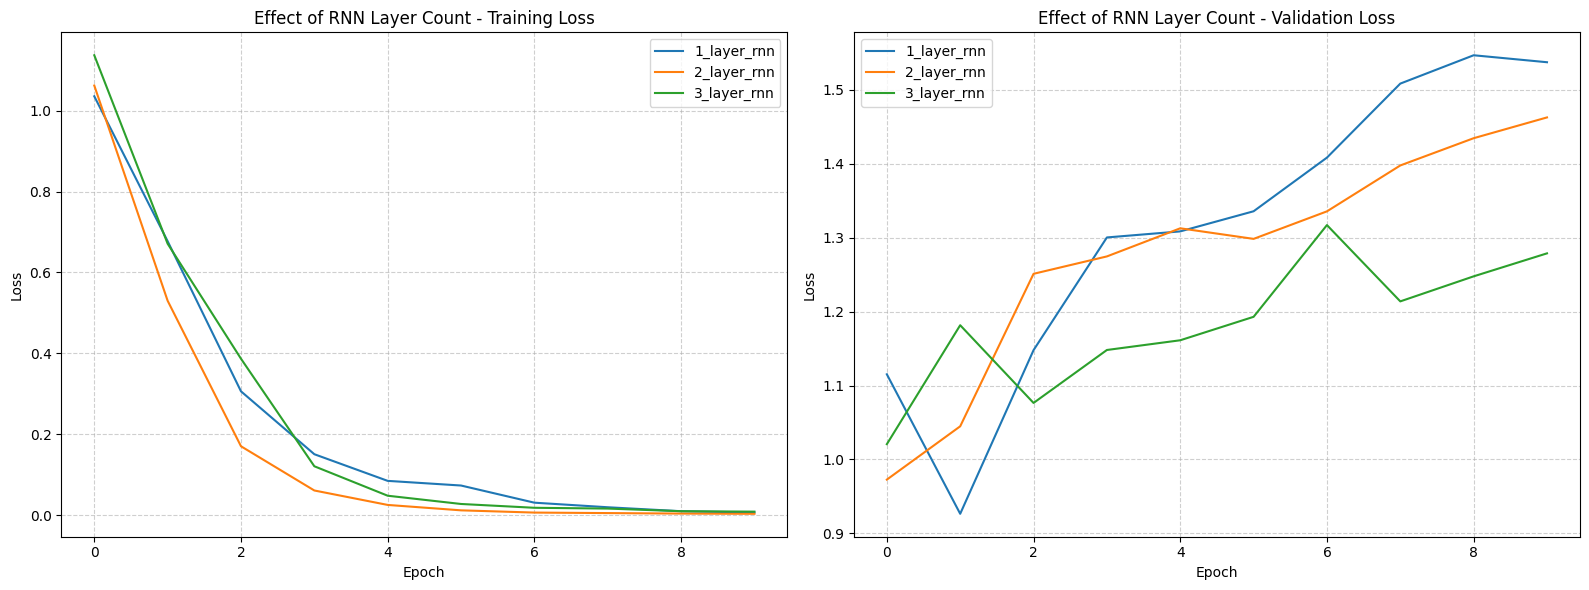

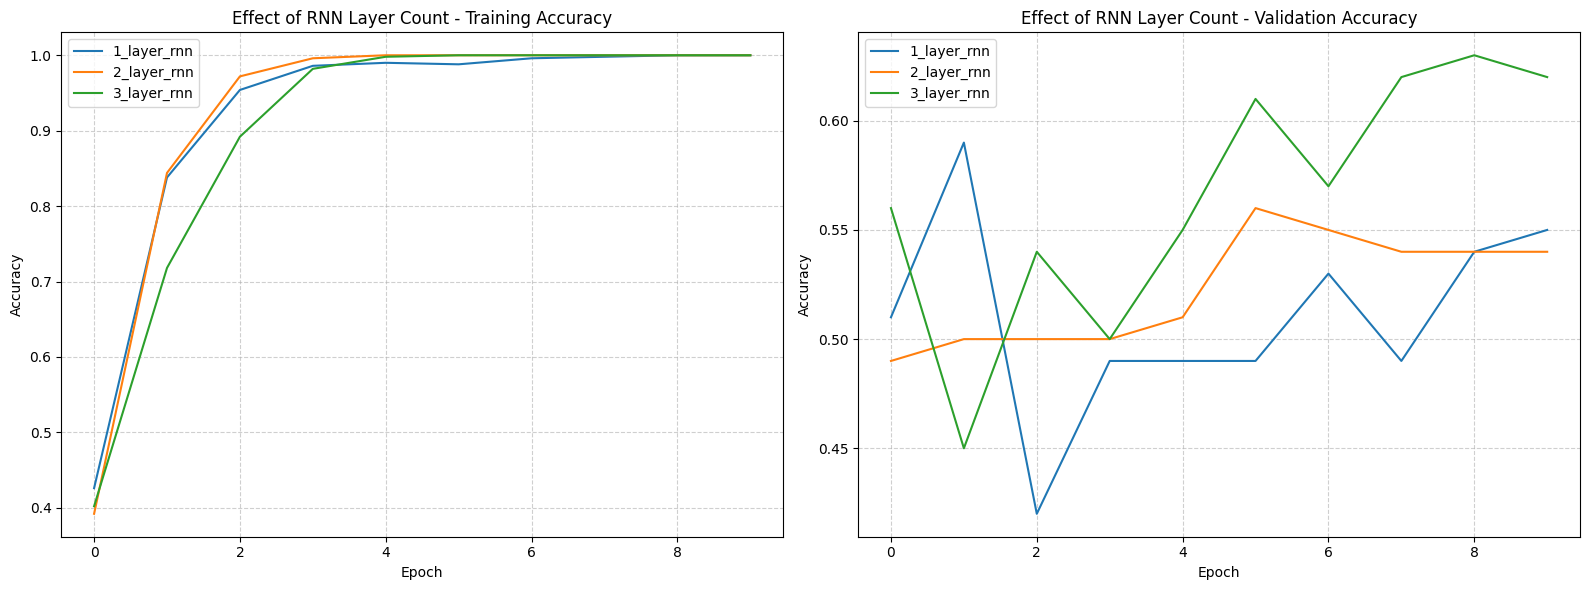

In [12]:
def plot_comparison(histories, metric="loss", title="Effect of RNN Layer Count"):
    """Plot comparison of training histories"""
    # Create separate plots for training and validation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Training plot
    for history, name in histories:
        ax1.plot(history.history[metric], label=f"{name}")
    
    ax1.set_title(f"{title} - Training {metric.capitalize()}")
    ax1.set_ylabel(metric.capitalize())
    ax1.set_xlabel("Epoch")
    ax1.legend(loc="best")
    ax1.grid(True, linestyle="--", alpha=0.6)
    
    # Validation plot
    for history, name in histories:
        ax2.plot(history.history[f"val_{metric}"], label=f"{name}")
    
    ax2.set_title(f"{title} - Validation {metric.capitalize()}")
    ax2.set_ylabel(metric.capitalize())
    ax2.set_xlabel("Epoch")
    ax2.legend(loc="best")
    ax2.grid(True, linestyle="--", alpha=0.6)
    
    plt.tight_layout()
    plt.savefig(
        f"../../output/results/rnn/{title.lower().replace(' ', '_')}_{metric}_comparison.png"
    )
    plt.show()

# Plot loss comparison
plot_comparison(histories, metric="loss", title="Effect of RNN Layer Count")

# Plot accuracy comparison
plot_comparison(histories, metric="accuracy", title="Effect of RNN Layer Count")

## Analysis and Conclusion

Let's analyze the results and draw conclusions about the effect of layer count on RNN performance.

In [13]:
# Compare final metrics
final_metrics = []

for model, name in models:
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    
    # Calculate F1-score
    y_pred = np.argmax(model.predict(x_test), axis=1)
    f1 = f1_score(y_test, y_pred, average="macro")
    
    final_metrics.append({
        "name": name,
        "loss": test_loss,
        "accuracy": test_acc,
        "f1_score": f1
    })

# Create a comparison table
import pandas as pd
metrics_df = pd.DataFrame(final_metrics)
metrics_df.set_index("name", inplace=True)
print("Final Metrics Comparison:")
display(metrics_df)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Final Metrics Comparison:


,loss,accuracy,f1_score
name,,,
1_layer_rnn,1.525880,0.5000,0.491713
2_layer_rnn,1.739005,0.4950,0.490606
3_layer_rnn,1.234012,0.6225,0.572826


## Conclusion on RNN Layer Count

Based on the experiments, we can observe the following effects of increasing RNN layer count:

1. **Training Dynamics**: 
   - [Insert observations about training curves]

2. **Model Performance**:
   - [Insert observations about accuracy and F1-score]

3. **Generalization**:
   - [Insert observations about overfitting/underfitting]

4. **Efficiency**:
   - [Insert observations about training time and model complexity]

The optimal layer count for this dataset appears to be [insert conclusion].

This experiment demonstrates that the number of RNN layers significantly impacts the model's ability to capture sequential patterns in text data for sentiment classification.